In [100]:
import osmnx as ox
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import pandas as pd


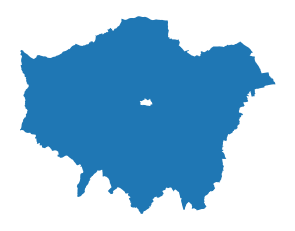

In [101]:

city = ox.geocode_to_gdf('London, UK')
ax = ox.project_gdf(city).plot()
_ = ax.axis('off')

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



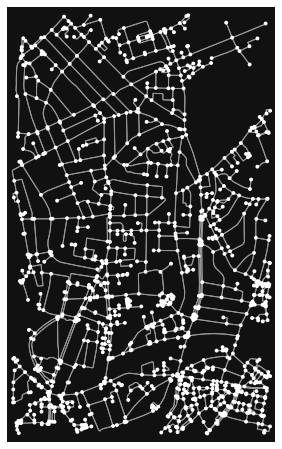

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [102]:
# Defining the map boundaries 
north, east, south, west = 51.566326, -0.084415, 51.544075, -0.106407 
# Downloading the map as a graph object 
G = ox.graph_from_bbox(north, south, east, west, network_type = 'walk')  
# Plotting the map graph 
ox.plot_graph(G)

In [103]:
list(G.edges(data=True))[1]

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(107032,
 2525016991,
 {'osmid': 7742058,
  'name': 'Church Road',
  'highway': 'residential',
  'maxspeed': '20 mph',
  'oneway': False,
  'length': 5.385999999999999,
  'geometry': <shapely.geometry.linestring.LineString at 0x7fa1823137c0>})

In [104]:
# define origin and desination locations 
origin_point = (51.546818, -0.103047) 
destination_point = (51.564307, -0.086708)
# get the nearest nodes to the locations 
origin_node = ox.get_nearest_node(G, origin_point) 
destination_node = ox.get_nearest_node(G, destination_point)
# printing the closest node id to origin and destination points origin_node, destination_node

In [105]:
def get_shortest_path(G,origin_node, destination_node):
    route = nx.shortest_path(G,origin_node,destination_node,weight = 'length')

In [106]:
# Finding the optimal path 
route = nx.shortest_path(G, origin_node, destination_node, weight = 'length') 
route

[2364985205,
 2089623036,
 2364967673,
 336421250,
 336421150,
 336421133,
 336421129,
 488683988,
 4320789977,
 336255005,
 3974497396,
 3974497409,
 1754950893,
 336253000,
 213632423,
 2458621496,
 26798872,
 221754,
 1684049573,
 684302831,
 186367969,
 221840,
 727395522,
 727395437,
 652813863,
 199532,
 199533,
 2647507901,
 199534,
 2886985256,
 26799369,
 2647524388,
 26799358,
 199537,
 199528,
 199524,
 213622167,
 213600924,
 54916162,
 25894499,
 652814028,
 2074773201,
 918203082,
 25894494,
 7164228447,
 5573574731,
 918203065,
 918203067,
 199500,
 635910427,
 635910425,
 2592074449,
 199511,
 220873,
 27471690,
 261766967]

In [107]:
# getting coordinates of the nodes
# we will store the longitudes and latitudes in following list 
long = [] 
lat = []  
for i in route:
     point = G.nodes[i]
     long.append(point['x'])
     lat.append(point['y'])

In [108]:
def plot_path(lat, long, origin_point, destination_point):
    
    """
    Given a list of latitudes and longitudes, origin 
    and destination point, plots a path on a map
    
    Parameters
    ----------
    lat, long: list of latitudes and longitudes
    origin_point, destination_point: co-ordinates of origin
    and destination
    Returns
    -------
    Nothing. Only shows the map.
    """
    # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()

In [109]:
plot_path(lat, long, origin_point, destination_point)


In [110]:
def node_list_to_path(G, node_list):
    """
    Given a list of nodes, return a list of lines that together
    follow the path
    defined by the list of nodes.
    Parameters
    ----------
    G : networkx multidigraph
    route : list
        the route as a list of nodes
    Returns
    -------
    lines : list of lines given as pairs ( (x_start, y_start), 
    (x_stop, y_stop) )
    """
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    for u, v in edge_nodes:
        # if there are parallel edges, select the shortest in length
        data = min(G.get_edge_data(u, v).values(), 
                    key=lambda x: x['length'])
        # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
    return lines
    # getting the list of coordinates from the path 
    # (which is a list of nodes)
lines = node_list_to_path(G, route)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])

In [111]:
plot_path(lat2, long2, origin_point, destination_point)


In [112]:
## Playing With What other info we can get
buildings = ox.geometries.geometries_from_bbox(north, south, east, west, {"building": True})
buildings

,unique_id,osmid,element_type,name,wikidata,wikipedia,geometry,created_by,building,postal_code,...,source:housenumber,source:postcode,sky,disused:amenity,addr:suburb,contact:instagram,name:el,ways,type,building:parts
0,node/331880920,331880920,node,Upper Street Area Housing Office,NaN,NaN,POINT (-0.10343 51.54585),NaN,public,N1 1RE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/393523303,393523303,node,St John's Court,NaN,NaN,POINT (-0.09830 51.56483),NaN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/3242908303,3242908303,node,The Coffee Run,NaN,NaN,POINT (-0.10485 51.54591),NaN,kiosk,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,way/16945426,16945426,way,NaN,NaN,NaN,"POLYGON ((-0.10151 51.54555, -0.10151 51.54558...",NaN,apartments,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,way/20196749,20196749,way,NaN,NaN,NaN,"POLYGON ((-0.09486 51.56268, -0.09472 51.56268...",NaN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3655,relation/1613870,1613870,relation,NaN,NaN,NaN,"POLYGON ((-0.10150 51.55297, -0.10100 51.55291...",NaN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[55825821, 55825811]",multipolygon,NaN
3656,relation/3016073,3016073,relation,NaN,NaN,NaN,"POLYGON ((-0.10400 51.54820, -0.10398 51.54820...",NaN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[166768589, 226935366]",multipolygon,NaN
3657,relation/3208659,3208659,relation,The Castle Climbing Centre,NaN,NaN,"POLYGON ((-0.09270 51.56540, -0.09264 51.56541...",NaN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[238096138, 238096136, 237670946]",multipolygon,vertical
3658,relation/3267550,3267550,relation,NaN,NaN,NaN,"POLYGON ((-0.10161 51.55456, -0.10147 51.55455...",NaN,residential,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[242049880, 242049878, 242049877]",multipolygon,NaN


In [113]:
buildings.columns

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Index(['unique_id', 'osmid', 'element_type', 'name', 'wikidata', 'wikipedia',
       'geometry', 'created_by', 'building', 'postal_code',
       ...
       'source:housenumber', 'source:postcode', 'sky', 'disused:amenity',
       'addr:suburb', 'contact:instagram', 'name:el', 'ways', 'type',
       'building:parts'],
      dtype='object', length=146)

In [114]:
leisure = ox.geometries.geometries_from_bbox(north, south, east, west, {"leisure": True})
leisure

,unique_id,osmid,element_type,created_by,geometry,barrier,leisure,opening_hours,wheelchair,access,...,building:material,contact:website,roof:colour,roof:shape,natural,lit,note,ways,type,building:parts
0,node/267177617,267177617,node,Potlatch 0.9b,POINT (-0.08733 51.55859),NaN,playground,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/2911951649,2911951649,node,NaN,POINT (-0.10229 51.55831),NaN,sports_centre,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/3761699415,3761699415,node,NaN,POINT (-0.10591 51.55984),NaN,playground,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/3785449138,3785449138,node,NaN,POINT (-0.08700 51.56164),NaN,pitch,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/3811569428,3811569428,node,NaN,POINT (-0.09242 51.56611),NaN,playground,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,relation/2678893,2678893,relation,NaN,"MULTIPOLYGON (((-0.09201 51.54883, -0.09195 51...",NaN,garden,NaN,NaN,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[198580778, 198580779, 242056790, 242056171]",multipolygon,NaN
111,relation/3016074,3016074,relation,NaN,"POLYGON ((-0.10307 51.54813, -0.10304 51.54809...",NaN,playground,NaN,NaN,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[32073325, 226935365, 226935364, 226935367, 24...",multipolygon,NaN
112,relation/3208659,3208659,relation,NaN,"POLYGON ((-0.09270 51.56540, -0.09264 51.56541...",NaN,sports_centre,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[238096138, 238096136, 237670946]",multipolygon,vertical
113,relation/4202259,4202259,relation,NaN,"POLYGON ((-0.09685 51.54961, -0.09676 51.54965...",NaN,pitch,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[158999942, 158999943]",multipolygon,NaN


In [115]:
leisure.leisure.value_counts()

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



pitch             48
garden            20
park              20
playground        18
swimming_pool      4
sports_centre      2
bandstand          1
bowling_alley      1
nature_reserve     1
Name: leisure, dtype: int64

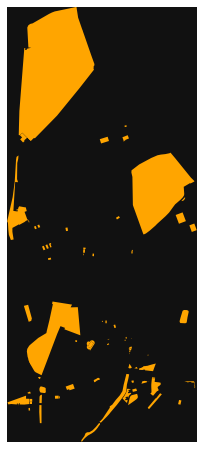

In [116]:
fig, ax = ox.plot_footprints(leisure)

In [117]:
trees = pd.read_csv(os.path.join('data files','dta','london_street_trees_gla_20180214.csv'))

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



In [118]:
trees.head()

,gla_id,borough,species_name,common_name,display_name,load_date,easting,northing,longitude,latitude
0,glaid_0,Barking,Acer pseudoplatanus 'brilliantissimum',NaN,Maple,20180214,548320.0,189593.0,0.139454,51.585695
1,glaid_1,Barking,Taxus baccata fastigiata,NaN,Other,20180214,548297.0,189590.0,0.139123,51.585670
2,glaid_2,Barking,Taxus baccata fastigiata,NaN,Other,20180214,548289.0,189592.0,0.139004,51.585689
3,glaid_3,Barking,Taxus baccata fastigiata,NaN,Other,20180214,548298.0,189597.0,0.139134,51.585732
4,glaid_4,Barking,Robinia pseudoacacia,NaN,Black Locust,20180214,548308.0,189607.0,0.139288,51.585819


In [119]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,y,x,street_count,highway,geometry
osmid,,,,,
107032,51.544361,-0.091933,3,NaN,POINT (-0.09193 51.54436)
198066,51.547655,-0.105806,3,NaN,POINT (-0.10581 51.54765)
199500,51.563605,-0.093326,4,NaN,POINT (-0.09333 51.56360)
199503,51.562640,-0.096278,4,NaN,POINT (-0.09628 51.56264)
199504,51.563045,-0.096957,3,NaN,POINT (-0.09696 51.56304)


In [120]:
len(gdf_nodes)

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



1210

In [121]:
EARTH_R = 6372.8
def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two
    points in geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt(
            (np.cos(lat1)*np.sin(dlon))**2
            +(np.cos(lat0)*np.sin(lat1) 
            -np.sin(lat0)*np.cos(lat1)* \
            np.cos(dlon))**2)
    x = np.sin(lat0)*np.sin(lat1) + \
        np.cos(lat0)*np.cos(lat1)*np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [122]:
distances = []
for i in range(len(trees)):
    distances.append(geocalc(gdf_nodes.loc[107032,'y'],gdf_nodes.loc[107032,'x'],
        trees.loc[i,'latitude'],trees.loc[i,'longitude']))

In [123]:
print(trees.loc[0,'latitude'],trees.loc[0,'longitude'])
print(gdf_nodes.loc[107032,'y'],gdf_nodes.loc[107032,'x'])


51.585695132483394 0.1394544528911636
51.5443608 -0.0919334


In [124]:
geocalc(trees.loc[0,'latitude'],trees.loc[0,'longitude'],gdf_nodes.loc[107032,'y'],gdf_nodes.loc[107032,'x'])

16.64590690708219

In [125]:
print(north,south)
print(east, west)

51.566326 51.544075
-0.084415 -0.106407


In [130]:
trees.dtypes

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



gla_id           object
borough          object
species_name     object
common_name      object
display_name     object
load_date         int64
easting         float64
northing        float64
longitude       float64
latitude        float64
dtype: object

In [148]:
area_trees = trees[((trees['latitude']>=float(south))&(trees['latitude']<=float(north)))&((trees['longitude']>=float(west))&(trees['longitude']<=float(east)))].reset_index()

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [139]:
area_trees.shape

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(7342, 10)

In [150]:
area_trees.head()

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,index,gla_id,borough,species_name,common_name,display_name,load_date,easting,northing,longitude,latitude
0,489543,glaid_489543,TFL,NaN,Lime,Lime,20180214,531535.0,186867.0,-0.103687,51.565362
1,489544,glaid_489544,TFL,NaN,Plane,Plane,20180214,531508.0,186845.0,-0.104097,51.565169
2,489545,glaid_489545,TFL,NaN,Plane,Plane,20180214,531530.0,186862.0,-0.103766,51.565317
3,491066,glaid_491066,TFL,NaN,Lime,Lime,20180214,531548.0,186879.0,-0.103497,51.565469
4,491700,glaid_491700,TFL,NaN,Plane,Plane,20180214,531390.0,186734.0,-0.105830,51.564199


In [146]:
gdf_nodes.iloc[0]

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



y                                   51.544361
x                                   -0.091933
street_count                                3
highway                                   NaN
geometry        POINT (-0.0919334 51.5443608)
Name: 107032, dtype: object

In [153]:
distances = []
ll = []
for i in range(len(area_trees)):
    distances.append(geocalc(51.544361,-0.091933,
        area_trees.loc[i,'latitude'],area_trees.loc[i,'longitude']))
    ll.append((area_trees.loc[i,'latitude'],area_trees.loc[i,'longitude']))
    

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [154]:
results = pd.DataFrame({'loc':ll,'distance':distances})
results.head()

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,loc,distance
0,"(51.56536151848566, -0.1036866201897075)",2.473201
1,"(51.56516941883454, -0.1040971683645528)",2.462586
2,"(51.56531694595688, -0.1037663889328679)",2.470341
3,"(51.5654690687986, -0.1034974591627448)",2.480253
4,"(51.56419923850091, -0.1058299526090344)",2.406755


In [155]:
results.sort_values(by ='distance')

/Users/taylorbrownlow/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,loc,distance
6466,"(51.54441157194634, -0.0917815958048606)",0.011888
6467,"(51.54433598923323, -0.0921271349487262)",0.013714
6461,"(51.544494607007564, -0.0918555681389935)",0.015796
6468,"(51.544263382282885, -0.0922852076461928)",0.026673
6469,"(51.544334608973344, -0.0923464063227068)",0.028747
...,...,...
0,"(51.56536151848566, -0.1036866201897075)",2.473201
2341,"(51.56494882588803, -0.1056167145127363)",2.477743
3,"(51.5654690687986, -0.1034974591627448)",2.480253
2340,"(51.56501244991096, -0.1056140701346609)",2.484215
